# Train and evaluate DFR on ImageNet-9 variations

In [1]:
import sys
import numpy as np
import torch
import torchvision
import einops
import json
import tqdm

from matplotlib import pyplot as plt

import sys
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
device = torch.device("cuda:2")

learning_rate = 0.1
num_epochs = 2000

ns = [1000, 5000, 10000, 20000, 45405]
num_seeds = 5

In [3]:
map_to_in9 = {}
with open('in_to_in9.json', 'r') as f:
    map_to_in9.update(json.load(f))

def load_embeddings(path):
    arr = np.load(path)
    x, y = arr["embeddings"], arr["labels"]
    if np.max(y) > 9:
        y = np.array([map_to_in9[str(y_)] for y_ in y])
        mask = y != -1
        x, y = x[mask], y[mask]
    return x, y

In [4]:
def train_logreg(
    x_train, y_train, eval_datasets,
    n_epochs=1000, weight_decay=0., lr=1.,
    verbose=0
    ):
    
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).long().to(device)
    
    d = x_train.shape[1]

    model = torch.nn.Sequential(
        torch.nn.Linear(d, 2048),  
        torch.nn.ReLU(),
        torch.nn.Linear(2048, 9)  
    ).to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), weight_decay=weight_decay, lr=lr)
    schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        schedule.step()
        acc = (torch.argmax(pred, -1) == y_train).detach().float().mean()
        if verbose > 1 and epoch % (n_epochs // 10) == 0:
            print(epoch, acc)
    
    results = {}
    for key, (x_test, y_test) in eval_datasets.items():
        x_test = torch.from_numpy(x_test).float().to(device)
        pred = torch.argmax(model(x_test), axis=-1).detach().cpu().numpy()
        results[key] = (pred == y_test).mean()
    
    pred = torch.argmax(model(x_train), axis=-1)
    results["train"] = (pred == y_train).detach().cpu().float().mean().item()

    return model, results

def get_data(
    train_datasets, eval_datasets, 
    num_mixrand=-1, num_original=0, preprocess=True):
    
    x_train, y_train = train_datasets["bgc_original"]
    idx = np.arange(len(x_train))
    np.random.shuffle(idx)
    idx = idx[:num_original]
    x_train = x_train[idx]
    y_train = y_train[idx]

    x_train_mr, y_train_mr = train_datasets["bgc_mixedrand"]
    idx = np.arange(len(x_train_mr))
    np.random.shuffle(idx)
    idx = idx[:num_mixrand]
    x_train_mr = x_train_mr[idx]
    y_train_mr = y_train_mr[idx]

    x_train = np.concatenate([x_train, x_train_mr])
    y_train = np.concatenate([y_train, y_train_mr])

    if preprocess:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        eval_datasets_preprocessed = {
            k: (scaler.transform(x), y)
            for k, (x, y) in eval_datasets.items()
        }
    else:
        eval_datasets_preprocessed = eval_datasets
    return x_train, y_train, eval_datasets_preprocessed


def run_experiment(
    train_datasets, eval_datasets,
    num_mixrand=-1, num_original=0, preprocess=True,
    n_epochs=1000, weight_decay=0., lr=1., verbose=0,
    num_seeds=3
):
    print(lr)
    print(weight_decay)
    print(n_epochs)
    results = {}
    for seed in range(num_seeds):
        x_train, y_train, eval_datasets_preprocessed = get_data(
            train_datasets, eval_datasets,
            num_mixrand, num_original, preprocess)
        _, results_seed = train_logreg(
            x_train, y_train, eval_datasets_preprocessed,
            n_epochs, weight_decay, lr, verbose)
        results[seed] = results_seed
    
    results_aggrgated = {
        key: (np.mean([results[seed][key] for seed in results.keys()]),
              np.std([results[seed][key] for seed in results.keys()]))
        for key in results[0].keys()
    }
    return results, results_aggrgated


def print_results(results_dict):
    print("-------------------")
    for key, val in results_dict.items():
        print("{}: {:.3f}±{:.3f}".format(key, val[0], val[1]))
    print("-------------------")

In [5]:
def mixrand_run(ns, n_epochs, lr, train_datasets, eval_datasets, num_seeds):
    mixrand_results_ns = []
    for n in ns:
        num_mixrand = n
        num_original = 0

        n_data = num_mixrand + num_original
        wd = 100 / n_data
        seed_results, results_aggrgated = run_experiment(
            train_datasets, eval_datasets,
            num_mixrand, num_original, lr=lr, weight_decay=wd, n_epochs=n_epochs,
            num_seeds=num_seeds)
        print_results(results_aggrgated)
        mixrand_results_ns.append(results_aggrgated)
    return mixrand_results_ns


def combo_run(ns, n_epochs, lr, train_datasets, eval_datasets, num_seeds):
    combo_results_ns = []
    for n in ns:
        num_mixrand = n
        num_original = n

        n_data = num_mixrand + num_original
        wd = 100 / n_data
        seed_results, results_aggrgated = run_experiment(
            train_datasets, eval_datasets,
            num_mixrand, num_original, lr=lr, weight_decay=wd, n_epochs=n_epochs,
            num_seeds=num_seeds)
        print_results(results_aggrgated)
        combo_results_ns.append(results_aggrgated)
    return combo_results_ns

In [6]:
def plot_results_indv(key, ax, ns, mixrand_results_ns, combo_results_ns, results_original):
    mixrand_mu = np.array([results[key][0] for results in mixrand_results_ns])
    mixrand_sigma = np.array([results[key][1] for results in mixrand_results_ns])

    original_mu = np.array([results_original[key][0] for _ in ns])
    original_sigma = np.array([results_original[key][1] for _ in ns])

    combo_mu = np.array([results[key][0] for results in combo_results_ns])
    combo_sigma = np.array([results[key][1] for results in combo_results_ns])
    ax.plot(ns, mixrand_mu, "-bo", label="DFR MR")
    ax.fill_between(ns, mixrand_mu + mixrand_sigma, mixrand_mu - mixrand_sigma,
                   color="b", alpha=0.3)
    ax.plot(ns, combo_mu, "-ro", label="DFR MR + Og")
    ax.fill_between(ns, combo_mu + combo_sigma, combo_mu - combo_sigma,
                    color="r", alpha=0.3)
    ax.plot(ns, original_mu, "--g", label="DFR Og")
    ax.fill_between(ns, original_mu + original_sigma, original_mu - original_sigma,
                    color="g", alpha=0.3)
    
    ax.legend()
    ax.set_xlabel("# MixedRand Data", fontsize=12)
    ax.set_ylabel(f"{key} Test Acc", fontsize=12)

def plot_all_results_indv(mixrand_results_ns, combo_results_ns, results_original):
    f, arr = plt.subplots(1, 5, figsize=(16, 3))

    plot_results_indv("bgc_mixedrand", arr[0], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("bgc_fg", arr[1], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("bgc_original", arr[2], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("imagenet_r", arr[3], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("imagenet_a", arr[4], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)

    plt.tight_layout()

## Original Network

In [7]:
use_prev_layer = False

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/imagenet-r_{use_prev_layer}_val_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/imagenet-a_{use_prev_layer}_val_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/bg_challenge_{use_prev_layer}_val_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/jennyni/datasets/original/bg_challenge_{use_prev_layer}_train_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/bg_challenge_{use_prev_layer}_train_embeddings.npz",

}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [8]:
_, results_original_ori = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_ori)

0.1
0.0022024006166721727
2000
-------------------
imagenet_r: 0.551±0.000
imagenet_a: 0.372±0.003
bgc_original: 0.980±0.000
bgc_fg: 0.930±0.001
bgc_mixedrand: 0.866±0.001
train: 0.996±0.000
-------------------


In [ ]:
mixrand_results_ns_ori = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_ori = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

0.1
0.1
2000
-------------------
imagenet_r: 0.496±0.016
imagenet_a: 0.289±0.011
bgc_original: 0.943±0.003
bgc_fg: 0.900±0.006
bgc_mixedrand: 0.873±0.004
train: 0.995±0.002
-------------------
0.1
0.02
2000
-------------------
imagenet_r: 0.536±0.012
imagenet_a: 0.286±0.004
bgc_original: 0.957±0.003
bgc_fg: 0.921±0.003
bgc_mixedrand: 0.906±0.002
train: 0.998±0.000
-------------------
0.1
0.01
2000
-------------------
imagenet_r: 0.545±0.003
imagenet_a: 0.286±0.005
bgc_original: 0.961±0.002
bgc_fg: 0.935±0.002
bgc_mixedrand: 0.917±0.003
train: 0.998±0.000
-------------------
0.1
0.005
2000


In [ ]:
def plot_results(key, ax, ns, mixrand_results_ns, combo_results_ns, results_original):
    mixrand_mu = np.array([results[key][0] for results in mixrand_results_ns])
    mixrand_sigma = np.array([results[key][1] for results in mixrand_results_ns])

    original_mu = np.array([results_original[key][0] for _ in ns])
    original_sigma = np.array([results_original[key][1] for _ in ns])

    combo_mu = np.array([results[key][0] for results in combo_results_ns])
    combo_sigma = np.array([results[key][1] for results in combo_results_ns])
    ax.plot(ns, mixrand_mu, "-bo", label="DFR MR")
    ax.fill_between(ns, mixrand_mu + mixrand_sigma, mixrand_mu - mixrand_sigma,
                   color="b", alpha=0.3)
    ax.plot(ns, combo_mu, "-ro", label="DFR MR + Og")
    ax.fill_between(ns, combo_mu + combo_sigma, combo_mu - combo_sigma,
                    color="r", alpha=0.3)
    ax.plot(ns, original_mu, "--g", label="DFR Og")
    ax.fill_between(ns, original_mu + original_sigma, original_mu - original_sigma,
                    color="g", alpha=0.3)
    
    ax.legend()
    ax.set_xlabel("# MixedRand Data", fontsize=12)
    ax.set_ylabel(f"{key} Test Acc", fontsize=12)

In [ ]:
print(results_original_ori)

In [ ]:
plot_all_results_indv(mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)

## Pre Projection

In [ ]:
use_ph = False

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/new_ph_imagenet-r_{use_ph}_val_standardSL_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/new_ph_imagenet-a_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/new_ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/new_ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/new_ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/jennyni/datasets/original/new_ph_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/new_ph_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [ ]:
_, results_original_pre = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_pre)

In [ ]:

mixrand_results_ns_pre = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_pre = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

In [ ]:
plot_all_results_indv(mixrand_results_ns_pre, combo_results_ns_pre, results_original_pre)

## Post Projection

In [ ]:
use_ph = True

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/new_ph_imagenet-r_{use_ph}_val_standardSL_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/new_ph_imagenet-a_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/new_ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/new_ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/new_ph_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/jennyni/datasets/original/new_ph_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/new_ph_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [ ]:
_, results_original_post = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_post)

In [ ]:

mixrand_results_ns_post = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_post = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

In [ ]:
plot_all_results_indv(mixrand_results_ns_post, combo_results_ns_post, results_original_post)

## Out of Distribution Accuracy vs In Distribution Accuracy 

In [1]:
mixrand_results_ns_ori = [{'imagenet_r': (0.5096402305704631, 0.01873010492093293), 'imagenet_a': (0.2927862697774202, 0.009138839466556992), 'bgc_original': (0.9414320987654323, 0.002881175732506615), 'bgc_fg': (0.8997037037037037, 0.009532783021837939), 'bgc_mixedrand': (0.8693827160493827, 0.001893361927178354), 'train': (0.9941999912261963, 0.0014697025019362931)}, {'imagenet_r': (0.5285894123103425, 0.013375025814908237), 'imagenet_a': (0.2930544381871815, 0.013109458722404668), 'bgc_original': (0.9569382716049383, 0.0015027283016990534), 'bgc_fg': (0.9265185185185185, 0.005715609400979885), 'bgc_mixedrand': (0.9047901234567902, 0.00277423642571617), 'train': (0.9977599859237671, 0.0004454201248195073)}, {'imagenet_r': (0.5334658450937521, 0.008135790443861764), 'imagenet_a': (0.2847412174845803, 0.00801173040187536), 'bgc_original': (0.9632098765432099, 0.0033310463119091602), 'bgc_fg': (0.9346666666666665, 0.003050557078810962), 'bgc_mixedrand': (0.9182716049382715, 0.0020539885770948407), 'train': (0.9982399940490723, 0.00021540027766533707)}, {'imagenet_r': (0.5533691115086465, 0.005371223268935631), 'imagenet_a': (0.2920353982300885, 0.008200868832844146), 'bgc_original': (0.9641975308641977, 0.001497851939565756), 'bgc_fg': (0.9364444444444444, 0.00218960980517484), 'bgc_mixedrand': (0.9255308641975308, 0.002244606059726121), 'train': (0.9932100057601929, 0.00042354362930566863)}, {'imagenet_r': (0.5647783740806996, 0.0030040740496411257), 'imagenet_a': (0.29369804237060876, 0.0013289902594115037), 'bgc_original': (0.9665679012345679, 0.00048384982573492315), 'bgc_fg': (0.9408888888888889, 0.001042899362071228), 'bgc_mixedrand': (0.9327407407407409, 0.0011644272713631195), 'train': (0.9624666810035706, 0.000311890687689699)}]

mixrand_results_ns_pre = [{'imagenet_r': (0.521619293712317, 0.01627530350609814), 'imagenet_a': (0.30265486725663715, 0.024158148817343256), 'bgc_original': (0.9318024691358024, 0.0052247753733122276), 'bgc_fg': (0.8924444444444444, 0.0073256392276014985), 'bgc_mixedrand': (0.8613827160493827, 0.004040942725032857), 'train': (0.9944000005722046, 0.001356469624450057)}, {'imagenet_r': (0.5476843569866825, 0.005137527263692912), 'imagenet_a': (0.3050683829444892, 0.0034451031059805205), 'bgc_original': (0.9558024691358025, 0.0024592394267632036), 'bgc_fg': (0.9239012345679012, 0.004194334294831793), 'bgc_mixedrand': (0.9005925925925926, 0.0020456607582427645), 'train': (0.9975200057029724, 0.0006881754983614078)}, {'imagenet_r': (0.5577817531305904, 0.004998451803367161), 'imagenet_a': (0.30378117457763476, 0.010346436316177217), 'bgc_original': (0.9625679012345678, 0.0025450071558963316), 'bgc_fg': (0.9360987654320987, 0.002910649289539038), 'bgc_mixedrand': (0.9149135802469136, 0.0006362517889740779), 'train': (0.9979400038719177, 0.0002059027731564401)}, {'imagenet_r': (0.5684489498442986, 0.008828863916426942), 'imagenet_a': (0.307857334406007, 0.007229613428696001), 'bgc_original': (0.9654320987654321, 0.0015694072673650048), 'bgc_fg': (0.9405432098765433, 0.0019716014595236547), 'bgc_mixedrand': (0.9215308641975308, 0.0019404328596927106), 'train': (0.9921899914741517, 0.000253768096089915)}, {'imagenet_r': (0.5748360166964819, 0.000850556233267408), 'imagenet_a': (0.3149369804237061, 0.0018077017480668022), 'bgc_original': (0.9681481481481482, 0.0005630495926415283), 'bgc_fg': (0.9458765432098766, 0.0007554102983100253), 'bgc_mixedrand': (0.9300246913580246, 0.0009950341570177702), 'train': (0.9619381070137024, 0.00024102594165173588)}]

mixrand_results_ns_post = [{'imagenet_r': (0.49483866693169015, 0.021029019357321804), 'imagenet_a': (0.316331456154465, 0.01218393886895739), 'bgc_original': (0.9357037037037037, 0.00558614350316219), 'bgc_fg': (0.8819753086419754, 0.0029997713676024147), 'bgc_mixedrand': (0.8439506172839506, 0.007797153995224135), 'train': (0.9745999932289123, 0.003979957814047489)}, {'imagenet_r': (0.5180547273570529, 0.013217209498236942), 'imagenet_a': (0.3108071869133816, 0.011883219749447647), 'bgc_original': (0.9571358024691359, 0.0018843243484778997), 'bgc_fg': (0.9229135802469136, 0.001572511933638593), 'bgc_mixedrand': (0.8945679012345679, 0.0013065438573158505), 'train': (0.9898399949073792, 0.0011271143435780285)}, {'imagenet_r': (0.538620552574041, 0.007361096872635546), 'imagenet_a': (0.31622418879056047, 0.007822799327541688), 'bgc_original': (0.9622222222222223, 0.0011152187447542093), 'bgc_fg': (0.9305185185185184, 0.003479992677026706), 'bgc_mixedrand': (0.9074074074074074, 0.0032079766457109456), 'train': (0.9891600131988525, 0.0012435414637819967)}, {'imagenet_r': (0.5532233485721858, 0.003835843543484505), 'imagenet_a': (0.31863770447841244, 0.004533236065243321), 'bgc_original': (0.9667160493827159, 0.001706385436362569), 'bgc_fg': (0.9405925925925926, 0.002027700263471395), 'bgc_mixedrand': (0.9185679012345679, 0.0025773804149530764), 'train': (0.973200011253357, 0.0012045815207086552)}, {'imagenet_r': (0.5627774464983768, 0.001376464914720517), 'imagenet_a': (0.3209439528023599, 0.0018454975096900289), 'bgc_original': (0.9689382716049384, 0.0010522111482796522), 'bgc_fg': (0.9460740740740741, 0.0011108367288100481), 'bgc_mixedrand': (0.9239012345679013, 0.0014346507700083067), 'train': (0.9343640565872192, 0.00021098768807241224)}]

combo_results_ns_ori = [{'imagenet_r': (0.5222155966342013, 0.018520356761274778), 'imagenet_a': (0.31069991954947707, 0.014694650105503903), 'bgc_original': (0.963753086419753, 0.001213649948389574), 'bgc_fg': (0.9110617283950617, 0.005616184942009115), 'bgc_mixedrand': (0.8807901234567901, 0.002679439005679133), 'train': (0.9963000059127808, 0.0012083117324976009)}, {'imagenet_r': (0.5372026767375605, 0.010491383793585178), 'imagenet_a': (0.3157414856529901, 0.0045433775456256075), 'bgc_original': (0.9730370370370371, 0.0017626240293900817), 'bgc_fg': (0.9328888888888889, 0.004580629580367493), 'bgc_mixedrand': (0.9086419753086421, 0.002740629516150431), 'train': (0.997160005569458, 0.00030723473583826015)}, {'imagenet_r': (0.555409792619095, 0.0045729806600602095), 'imagenet_a': (0.32008581389112367, 0.004502035670996682), 'bgc_original': (0.9735308641975309, 0.001990068314035523), 'bgc_fg': (0.9372345679012346, 0.004003960849506083), 'bgc_mixedrand': (0.9186666666666667, 0.002442323559284578), 'train': (0.9929899930953979, 0.0003929443059650561)}, {'imagenet_r': (0.5576492413701717, 0.00414924771795397), 'imagenet_a': (0.3199249128452668, 0.004116188544778738), 'bgc_original': (0.9759506172839506, 0.0008916281523589152), 'bgc_fg': (0.9431604938271605, 0.0018437683656883639), 'bgc_mixedrand': (0.9267160493827161, 0.00102877366202468), 'train': (0.9774200081825256, 0.0005139008368670112)}, {'imagenet_r': (0.5613198171337707, 0.0026568525350511387), 'imagenet_a': (0.3240547063555913, 0.004792943011584639), 'bgc_original': (0.9770864197530864, 0.0008174294003578706), 'bgc_fg': (0.9454814814814816, 0.000846737195036152), 'bgc_mixedrand': (0.9309135802469136, 0.0015569266933762405), 'train': (0.9562493205070496, 0.00023099162411604582)}]

combo_results_ns_pre = [{'imagenet_r': (0.541456304247002, 0.012275296143151511), 'imagenet_a': (0.34743899168677933, 0.003134704037801555), 'bgc_original': (0.9623703703703702, 0.001657082640549373), 'bgc_fg': (0.9161975308641976, 0.0031060118900772993), 'bgc_mixedrand': (0.8737283950617284, 0.0042698205078948006), 'train': (0.9949000000953674, 0.0010198164899933393)}, {'imagenet_r': (0.5572649572649573, 0.007082676119822813), 'imagenet_a': (0.3396621078037007, 0.008063980593326293), 'bgc_original': (0.9733333333333334, 0.0010240217952260549), 'bgc_fg': (0.9321975308641974, 0.002666666666666668), 'bgc_mixedrand': (0.9062716049382716, 0.0021102084562194014), 'train': (0.9971199989318847, 0.0005230794624463923)}, {'imagenet_r': (0.5595044060160339, 0.008405738104731934), 'imagenet_a': (0.3386967015285599, 0.004334052850809758), 'bgc_original': (0.9749135802469135, 0.0007087753133040768), 'bgc_fg': (0.9408395061728395, 0.0025112458538451847), 'bgc_mixedrand': (0.9157530864197531, 0.0018830297249321194), 'train': (0.9918299913406372, 0.00012082189949268364)}, {'imagenet_r': (0.56768038163387, 0.008260915357618318), 'imagenet_a': (0.33912577098417807, 0.0060217991175374385), 'bgc_original': (0.9772345679012344, 0.0007554102983100442), 'bgc_fg': (0.9444938271604938, 0.001451549477204851), 'bgc_mixedrand': (0.9224197530864199, 0.0022271550190182177), 'train': (0.976419985294342, 0.0004945648526233646)}, {'imagenet_r': (0.5762538925329623, 0.0015479506364738528), 'imagenet_a': (0.34534727809064086, 0.00121595967270095), 'bgc_original': (0.9781728395061728, 0.00033492987570992323), 'bgc_fg': (0.9484444444444445, 0.0009025020682714349), 'bgc_mixedrand': (0.9258271604938271, 0.0014448137124274424), 'train': (0.9546217441558837, 0.0002922184086623979)}]

combo_results_ns_post = [{'imagenet_r': (0.5251176041873716, 0.012457627861873904), 'imagenet_a': (0.35060337892196297, 0.015650194435467404), 'bgc_original': (0.9609876543209876, 0.003142696805273544), 'bgc_fg': (0.9099753086419753, 0.004413057898814569), 'bgc_mixedrand': (0.8638024691358025, 0.003479992677026711), 'train': (0.9828000068664551, 0.0017776421506963908)}, {'imagenet_r': (0.534313920360432, 0.01153937791810132), 'imagenet_a': (0.339715741485653, 0.007890533625788364), 'bgc_original': (0.9729382716049383, 0.0012839506172839475), 'bgc_fg': (0.930320987654321, 0.002395952488041125), 'bgc_mixedrand': (0.8978765432098765, 0.0009185716166784324), 'train': (0.9882000088691711, 0.0006356028854626739)}, {'imagenet_r': (0.5452196382428941, 0.007372109312548478), 'imagenet_a': (0.347170823277018, 0.006534951073499309), 'bgc_original': (0.976246913580247, 0.0009550162768303025), 'bgc_fg': (0.9385185185185186, 0.0016153508379058172), 'bgc_mixedrand': (0.9080987654320989, 0.0018437683656883639), 'train': (0.9779700040817261, 0.0002541610435492735)}, {'imagenet_r': (0.55445570794408, 0.004708663280950434), 'imagenet_a': (0.3503352105122017, 0.0025133546825121954), 'bgc_original': (0.9782222222222222, 0.0007870309852103387), 'bgc_fg': (0.9439012345679012, 0.0012335798515355249), 'bgc_mixedrand': (0.9158518518518518, 0.0016108154499061957), 'train': (0.9600399851799011, 0.0002177255297446209)}, {'imagenet_r': (0.5615583383025242, 0.0011099392614521576), 'imagenet_a': (0.35237329042638776, 0.001449102288667888), 'bgc_original': (0.979358024691358, 0.0002518034327700307), 'bgc_fg': (0.9455308641975307, 0.0011748520744069278), 'bgc_mixedrand': (0.9200493827160494, 0.0007224068562137394), 'train': (0.9429952740669251, 0.0002781145714703164)}]


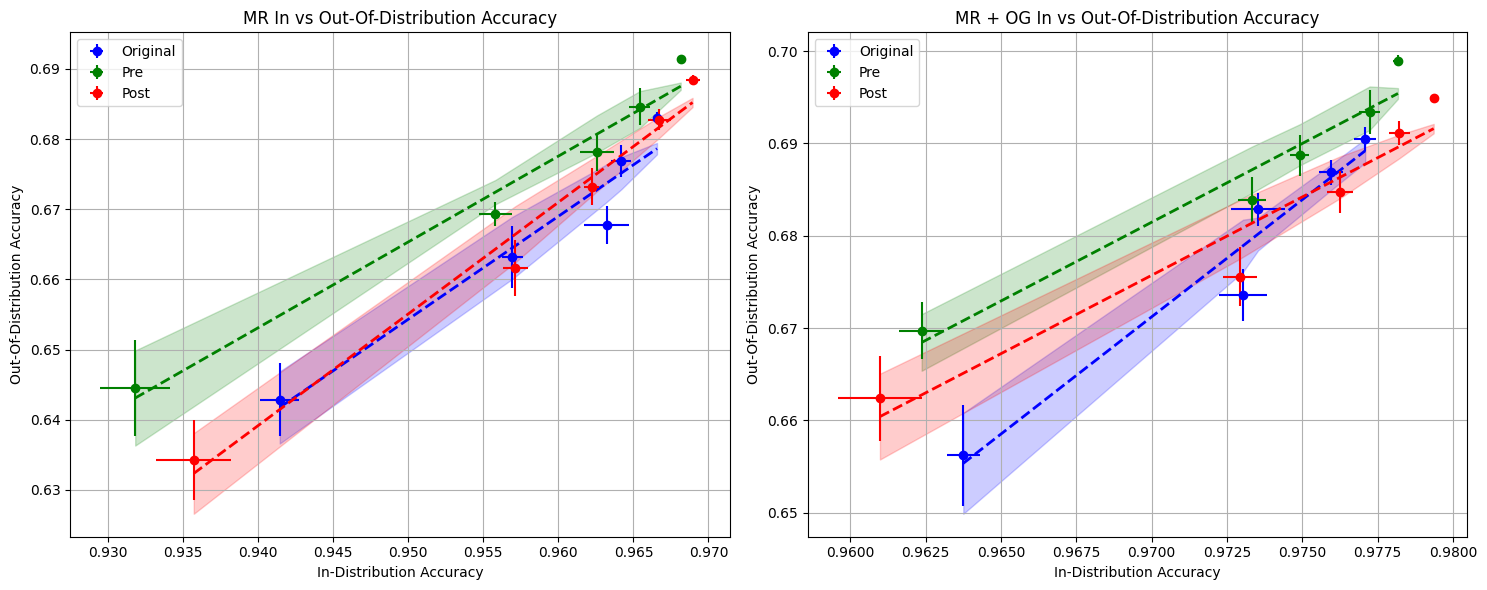

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def process_results(results):
    in_distrib_acc = []
    out_distrib_acc = []
    in_distrib_std = []
    out_distrib_std = []
    
    for res in results:
        in_distrib_acc.append(res['bgc_original'][0])
        in_distrib_std.append(res['bgc_original'][1])
        
        # out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train' and k != 'imagenet_a']
        # out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train' and k != 'imagenet_a']
        out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        
        out_distrib_acc.append(np.mean(out_distrib_means))
        out_distrib_std.append(np.sqrt(np.mean(np.array(out_distrib_stds) ** 2)))  # Pooled standard deviation
        
    return in_distrib_acc, out_distrib_acc, in_distrib_std, out_distrib_std


def plot_results(in_acc, out_acc, in_std, out_std, label, color, n=5, ax=None):
    in_err = np.array(in_std) / np.sqrt(n)
    out_err = np.array(out_std) / np.sqrt(n)

    if ax is None:
        ax = plt.gca() 

    ax.errorbar(in_acc, out_acc, xerr=in_err, yerr=out_err, fmt='o', label=label, color=color)
    slope, intercept, _, _, _ = stats.linregress(in_acc, out_acc)
    in_acc_line = np.array(in_acc)
    out_acc_line = slope * in_acc_line + intercept

    ax.plot(in_acc_line, out_acc_line, '--', lw=2, color=color)
    ax.fill_between(in_acc_line, out_acc_line - out_err, out_acc_line + out_err, alpha=0.2, color=color)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  

in_original, out_original, in_std_original, out_std_original = process_results(mixrand_results_ns_ori)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(mixrand_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(mixrand_results_ns_post)
axs[0].set_title('MR In vs Out-Of-Distribution Accuracy')
plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue', ax=axs[0])
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre', 'green', ax=axs[0])
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post', 'red', ax=axs[0])


in_original, out_original, in_std_original, out_std_original = process_results(combo_results_ns_ori)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(combo_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(combo_results_ns_post)

axs[1].set_title('MR + OG In vs Out-Of-Distribution Accuracy')
plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue', ax=axs[1])
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre', 'green', ax=axs[1])
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post', 'red', ax=axs[1])


for ax in axs:
    ax.set_xlabel('In-Distribution Accuracy')
    ax.set_ylabel('Out-Of-Distribution Accuracy')
    ax.legend()
    ax.grid(True)

plt.tight_layout()

plt.show()

In [ ]:
file_path = "projection_head_mlp.txt"

with open(file_path, "w") as file:
    file.write("MR_results_ori:\n")
    file.write(str(mixrand_results_ns_ori) + "\n\n")
    
    file.write("MR_results_pre:\n")
    file.write(str(mixrand_results_ns_pre) + "\n\n")
    
    file.write("MR_results_post:\n")
    file.write(str(mixrand_results_ns_post) + "\n\n")
    
    file.write("MROG_results_ori:\n")
    file.write(str(combo_results_ns_ori) + "\n\n")
    
    file.write("MROG_results_pre:\n")
    file.write(str(combo_results_ns_pre) + "\n\n")
    
    file.write("MROG_results_post:\n")
    file.write(str(combo_results_ns_post) + "\n\n")

print(f"Results saved to {file_path}")